In [482]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [483]:
import hackeeg
from hackeeg import ads1299
import keyboard

In [484]:
SERIAL_PORT_PATH = "/dev/cu.usbmodem143301"
SAMPLES_PER_SECOND = ads1299.HIGH_RES_1k_SPS
GAIN = ads1299.GAIN_1X
CHANNELS = 8

In [485]:
# Configure ADS1299
hackeeg = hackeeg.HackEEGBoard(serial_port_path=SERIAL_PORT_PATH)
hackeeg.connect()
hackeeg.blink_board_led()
hackeeg.sdatac()
hackeeg.reset()
hackeeg.disable_all_channels()

# Set sampling rate
hackeeg.wreg(ads1299.CONFIG1, SAMPLES_PER_SECOND | ads1299.CONFIG1_const)


for i in range(1, 9):
    hackeeg.wreg(ads1299.CHnSET + i, ads1299.ELECTRODE_INPUT | GAIN)

# Differential mode - each channel is the differential voltage between adjacent electrodes
hackeeg.wreg(ads1299.MISC1, ads1299.MISC1_const)
# For single-ended mode, uncomment the following line to set the SRB1 bit,
# which sends mid-supply voltage to the N inputs
# hackeeg.wreg(ads1299.MISC1, ads1299.SRB1 | ads1299.MISC1_const)

# hackeeg.wreg(ads1299.CONFIG4, ads1299.PD_LOFF_COMP | ads1299.CONFIG4_const)
# hackeeg.wreg(ads1299.LOFF_SENSP, 0b11111111)
# hackeeg.wreg(ads1299.LOFF_SENSN, 0b11111111)


# Set positive electrode of channel 7 to drive bias
# hackeeg.wreg(ads1299.CHnSET + 7, ads1299.BIAS_DRP)

# # Route BIASIN to be measured at channel 8 with respect to BIASREF
# hackeeg.wreg(ads1299.CHnSET + 8, ads1299.RLD_INPUT)

# Choose bias as an average of the first three channels
hackeeg.wreg(ads1299.BIAS_SENSP, ads1299.BIAS1P | ads1299.BIAS2P | ads1299.BIAS3P)
hackeeg.wreg(ads1299.BIAS_SENSN, ads1299.BIAS1N | ads1299.BIAS2N | ads1299.BIAS3N)
# Use internal BIASREF signal source and turn on bias amplifier
# route BIASOUT to bias electrode: JP9: 2-3, JP6: NC (not connected)
hackeeg.wreg(ads1299.CONFIG3, ads1299.BIASREF_INT | ads1299.PD_BIAS | ads1299.CONFIG3_const)



{'STATUS_CODE': 200, 'STATUS_TEXT': 'Ok'}

In [486]:
# Read data continuously for 5 seconds
hackeeg.messagepack_mode()
hackeeg.blink_board_led()
hackeeg.start()
hackeeg.rdatac()

print("Flex!")


samples = []
timestamp_contraction = []
t_end = time.time() + 5
while time.time() < t_end:
    result = hackeeg.read_rdatac_response()
    if result:
        samples.append(result)
        # if keyboard.is_pressed('space'):
            # timestamp_contraction.append(result.get('timestamp'))
    else:
        print("no data to decode")
        print(f"result: {result}")

print("Sampling complete")

Flex!
Sampling complete


In [487]:
# Process samples
channel_data = np.empty((9, len(samples)))
for i, s in enumerate(samples):
    dataKey = s.get(hackeeg.MpDataKey)
    if dataKey:
        timestamp = s.get('timestamp')
        data = s.get('channel_data')
        channel_data[0, i] = timestamp
        for channel in range(1,9):
            channel_data[channel, i] = data[channel-1]
channel_data = channel_data.astype(np.float64)
np.save('channel_data', channel_data)

In [488]:
loff_statn = map(lambda x: x.get("loff_statn"), samples)
loff_statp = map(lambda x: x.get("loff_statp"), samples)
pd.DataFrame({"loff_statn": loff_statn, "loff_statp": loff_statp})

,loff_statn,loff_statp
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
4951,0,0
4952,0,0
4953,0,0
4954,0,0


In [489]:
import pandas as pd

df = pd.DataFrame(data=channel_data.T).set_index(0)
df *= 2.5
df /= 2**23
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df



,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
timestamp,,,,,,,,
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
0.000192,-0.155115,-0.076076,0.715804,1.426706,0.251320,-2.5,-0.345460,2.500000
0.001191,-0.150927,0.186620,0.484971,1.422356,0.248376,-2.5,-1.283577,2.500000
0.002187,-0.138384,0.348733,0.308224,1.415429,0.244055,-2.5,-2.247337,2.500000
0.003188,-0.107685,0.423813,0.208330,1.423205,0.238107,-2.5,-2.500000,2.500000
...,...,...,...,...,...,...,...,...
4.943300,-0.081162,1.098996,-2.177684,1.412994,0.243782,-2.5,-1.073907,0.749740
4.944296,-0.080310,0.975426,-1.531781,1.419094,0.249646,-2.5,-0.977333,0.537305
4.945296,-0.074389,0.784612,-0.835061,1.428660,0.253903,-2.5,-0.828504,0.353466


In [490]:
# Sampled in bipolar mode; -2.5V - +2.5V
# 24-bit resolution ADC
# analog voltage measured = (ADC reading * system voltage) / resolution
analog_voltage = (channel_data[1:] * 2.5) / (2**23)
timestamps = channel_data[0]

Text(0.5, 1.0, 'FFT of signal')

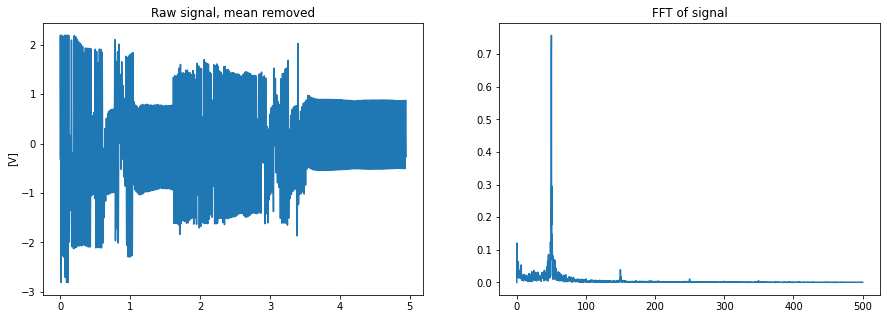

In [497]:
import scipy
from scipy import fftpack
sampling_rate = 1000


T = 1 / sampling_rate

y = df.channel_8
y = y - y.mean()
N = len(y)
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
y_fft = scipy.fftpack.fft(y.to_numpy())

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.title('Raw signal, mean removed')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT of signal')


 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

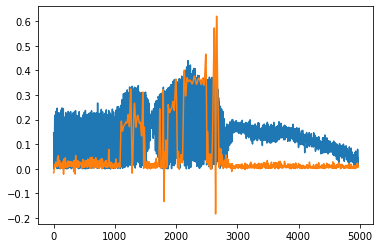

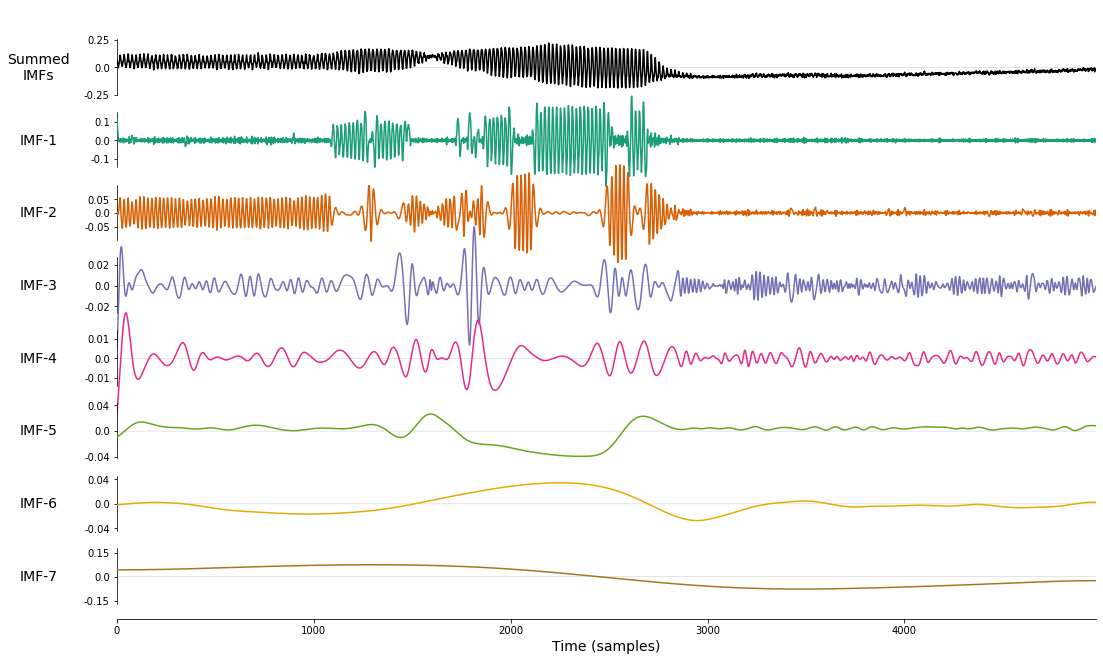

In [148]:
# EMD
import emd
seconds = 5
num_samples = seconds*sampling_rate

imf = emd.sift.sift(y - y.mean())
envelope = emd.sift.interp_envelope(imf, mode='upper')

plt.plot(abs(y-y.mean()))
plt.plot(envelope)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

Text(0.5, 1.0, 'FFT after bandpass filtering')

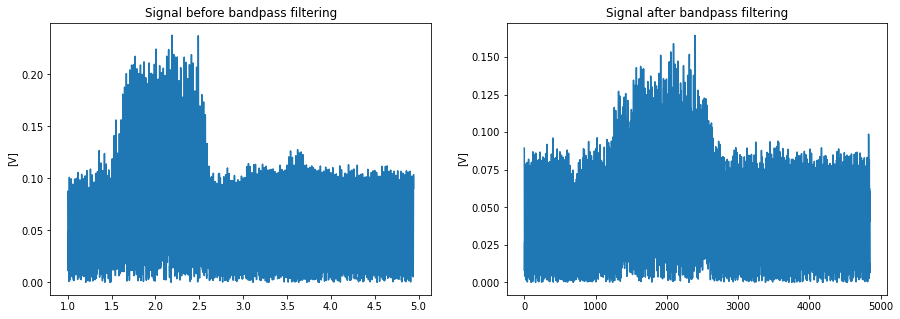

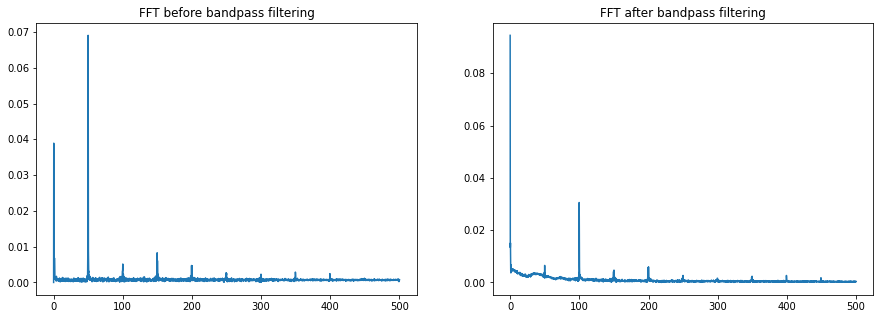

In [471]:
# Bandpass filter
high = 20/(sampling_rate/2)         # Normalized to Nyquist rate
low = 450/(sampling_rate/2)
b, a = scipy.signal.butter(4, [high,low], btype='bandpass')
y_butter = scipy.signal.filtfilt(b, a, y)
y_butter = abs(y_butter)

y_butter_fft = scipy.fftpack.fft(y_butter)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y[1:]))
plt.title('Signal before bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_butter[100:])
plt.title('Signal after bandpass filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before bandpass filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_butter_fft[:N//2]))
plt.title('FFT after bandpass filtering')


Text(0.5, 1.0, 'FFT after notch filtering')

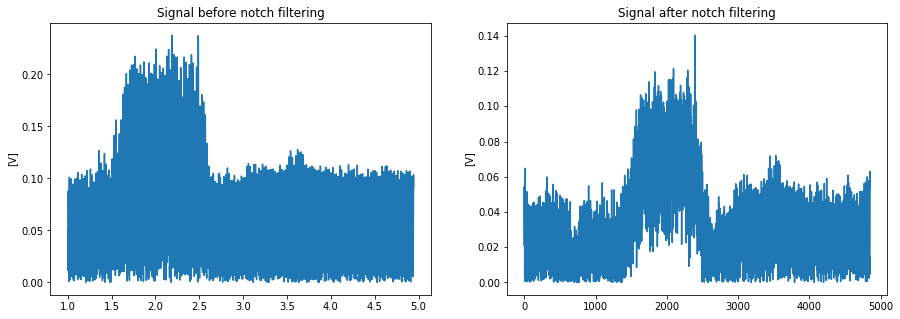

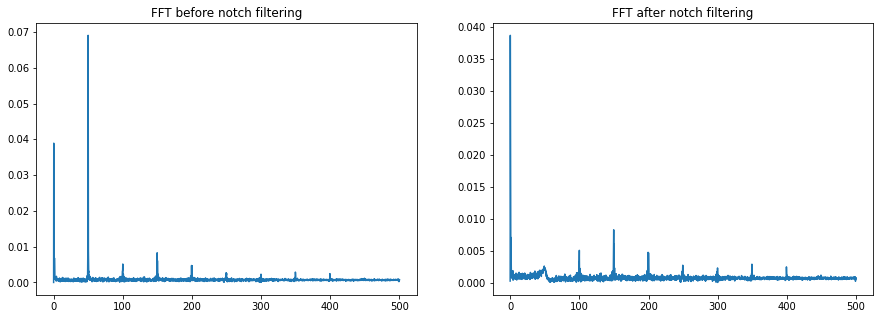

In [473]:
# Notch filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iirnotch(notch_freq, quality_factor, sampling_rate)

freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
y_notched = scipy.signal.filtfilt(b_notch, a_notch, y)
y_notched_fft = scipy.fftpack.fft(y_notched)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y[1:]))
plt.title('Signal before notch filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched[100:]))
plt.title('Signal after notch filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before notch filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_notched_fft[:N//2]))
plt.title('FFT after notch filtering')

Text(0, 0.5, '[V]')

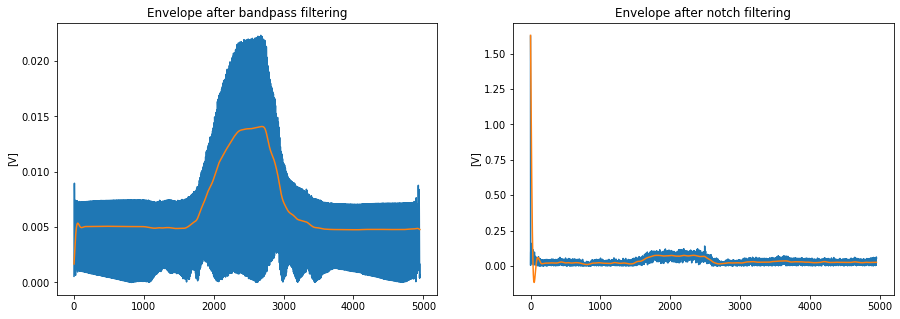

In [466]:
# Envelope
low_pass = 10/(sampling_rate/2)
b, a = scipy.signal.butter(3, low_pass, btype='lowpass')
envelope_b = scipy.signal.filtfilt(b, a, abs(y_butter))
envelope_n = scipy.signal.filtfilt(b, a, abs(y_notched))

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y_butter))
plt.plot(envelope_b)
plt.title('Envelope after bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched))
plt.plot(envelope_n)
plt.title('Envelope after notch filtering')
plt.ylabel('[V]')

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

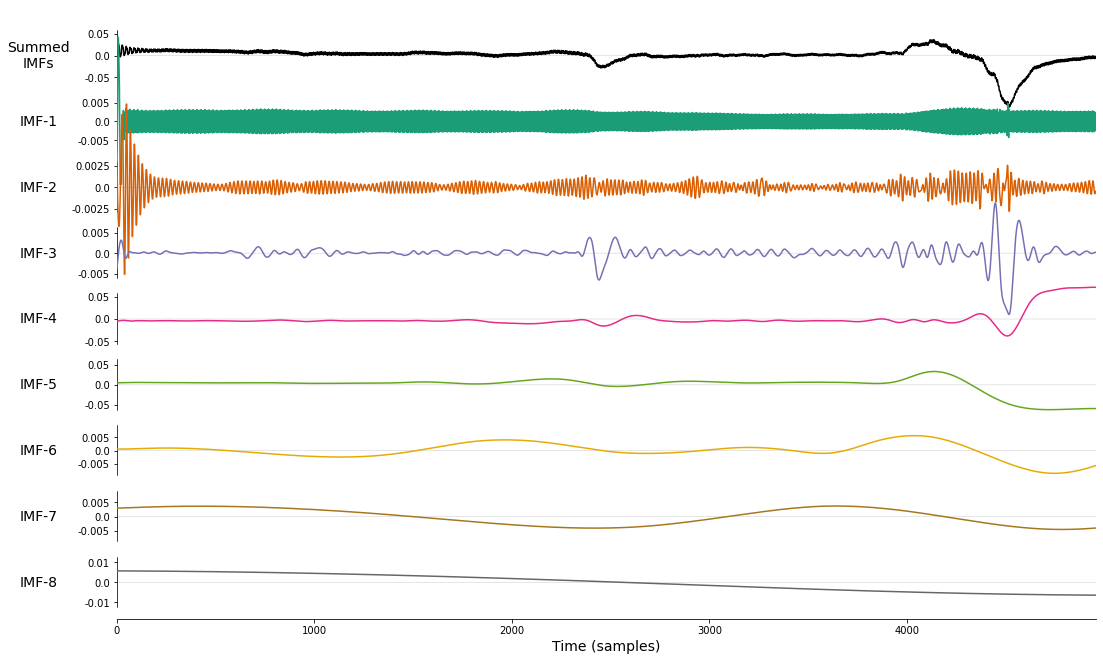

In [130]:
imf = emd.sift.sift(y_notched)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)